In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import matplotlib.pyplot as plt

1. Model Architecture.

In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer -1):
            self.linears.append( nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        #print("forward before x.size()", x.size())
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        #print("forward after  x.size()", x.size())
        return x
#net = MLP(3072, 10, 100, 4, 'relu')

2. 실험함수 정의하기

In [3]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr = args.lr, momentum=args.mm)

    list_epoch = []
    list_train_loss = []
    list_val_loss = []
    list_val_acc = []        

    for epoch in range(args.epoch):
        # Train
        net.train()
        
        train_loss = 0.0
        list_epoch.append( epoch )
        for i, data in enumerate(args.trainloader,0):
            inputs, labels = data
            inputs = inputs.view(-1, 3072)

            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)            
            loss.backward()
            optimizer.step()            
            train_loss += loss.item()            
        train_loss = train_loss / len(args.trainloader)
        # Validation
        net.eval()
        optimizer.zero_grad()

        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in args.valloader:
                images, labels = data
                images = images.view(-1, 3072)
                images = images.cuda()
                labels = labels.cuda()

                outputs2 = net(images)
                loss = criterion(outputs2, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs2, 1)
                total += labels.size(0)
                #print(":::::: predicted.size()", predicted.size(), "labels.size()", labels.size())
                correct += (predicted == labels).sum().item()
            val_loss = val_loss / len(args.valloader)
            val_acc = 100 * correct / total

        list_train_loss.append( train_loss )
        list_val_loss.append( val_loss )
        list_val_acc.append( val_acc )
        if epoch == args.epoch - 1: 
            print("Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss, val_loss, val_acc) )
    # Evaluation
    net.eval()
    optimizer.zero_grad()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in args.testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()        

            optputs3 = net(images)
            
            _, predicted = torch.max(optputs3, 1)
            total += labels.size(0)            
            correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total
    return list_epoch, list_train_loss, list_val_loss, list_val_acc, test_acc

2. Data Preparation

In [4]:
def preparationData():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    batch_size = 128 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)
    return (trainloader, valloader, testloader)

3. 인자값들 작성하기.

In [5]:
def makeArgs():
    seed = 123
    np.random.seed(seed)
    torch.manual_seed(seed)

    parser = argparse.ArgumentParser()
    args = parser.parse_args("")

    args.n_layer = 5
    args.in_dim = 3072
    args.out_dim = 10
    args.hid_dim = 100
    args.act = 'relu'

    args.lr = 0.0001
    args.mm = 0.9
    args.epoch = 10
    return args

4. visualization 함수 

In [6]:
def visualization(result):
    list_epoch, list_train_loss, list_val_loss, list_val_acc, test_acc = result 
    #(list_epoch, list_train_loss, list_val_loss, list_acc_epoch, list_acc) = result
    fig = plt.figure(figsize=(15,5))

    # ====== Loss Fluctuation ====== #
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(list_epoch, list_train_loss, label='train_loss')
    ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.grid()
    ax1.legend()
    ax1.set_title('epoch vs loss')

    # ====== Metric Fluctuation ====== #
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(list_epoch, list_val_acc, marker='x', label='Accuracy metric')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Acc')
    ax2.grid()
    ax2.legend()
    ax2.set_title('epoch vs validation Accuracy')

    plt.show()

5. 실행 메인함수 작성하기.

In [7]:
def main():
    # 1. 먼저 데이터를 준비하기.
    trainloader, valloader, testloader = preparationData()

    # 2. Arguments를 만들기.
    args = makeArgs()
    args.trainloader = trainloader
    args.valloader = valloader
    args.testloader = testloader

    # 3. 실험을 하기.
    list_var1 = [4, 5, 6]
    list_var2 = [50, 100, 150]

    for var1 in list_var1:
        for var2 in list_var2:
            args.n_layer = var1
            args.hid_dim = var2
            result = experiment(args)
            #print(result)

            visualization(result)

5. 실제로 함수 실행하기.

Files already downloaded and verified
Files already downloaded and verified
MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3000371220012825, Val Loss: 2.3004029430920565, Val Acc: 9.71


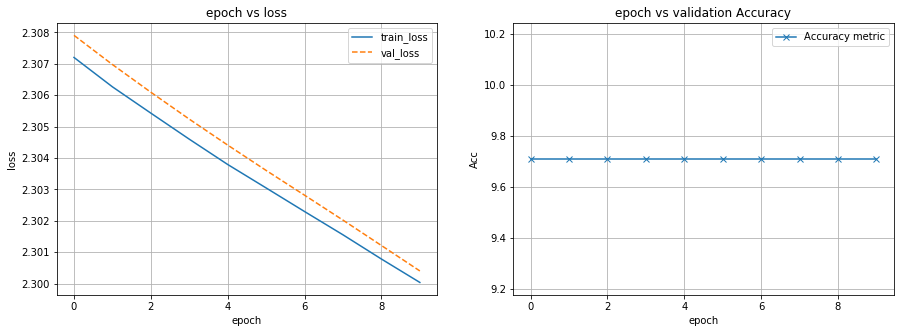

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.2976733084303884, Val Loss: 2.2976097275939167, Val Acc: 10.97


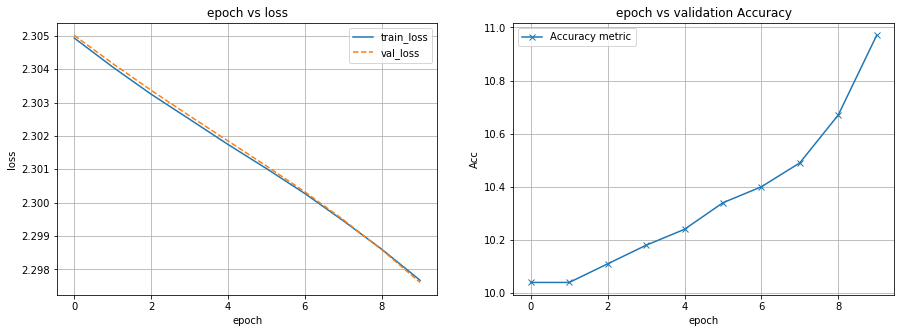

MLP(
  (fc): Linear(in_features=3072, out_features=150, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=150, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc2): Linear(in_features=150, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.297133316247227, Val Loss: 2.296632365335392, Val Acc: 14.32


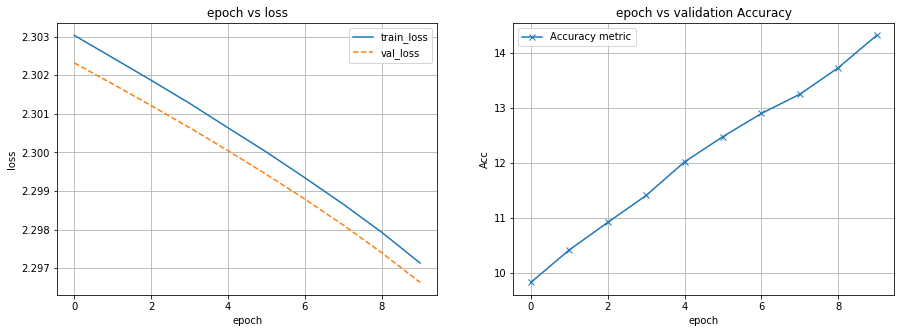

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3042918927372456, Val Loss: 2.3051265825199176, Val Acc: 9.58


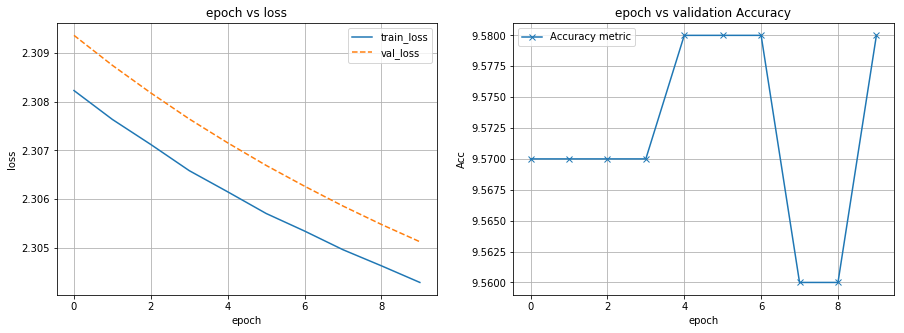

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3029238796843505, Val Loss: 2.3028997228115418, Val Acc: 9.69


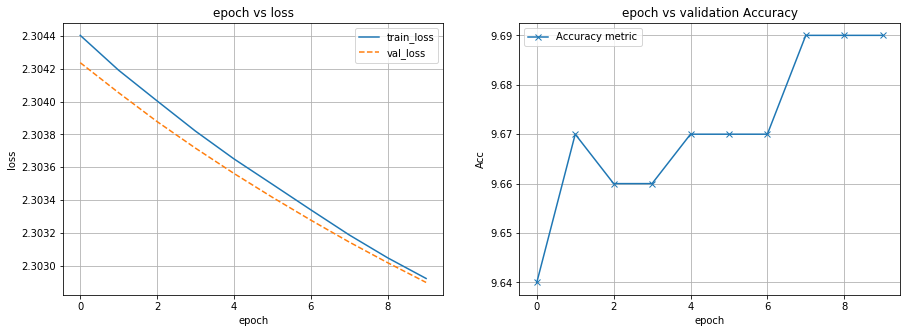

MLP(
  (fc): Linear(in_features=3072, out_features=150, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=150, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc2): Linear(in_features=150, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3023727328632586, Val Loss: 2.302759043778045, Val Acc: 9.57


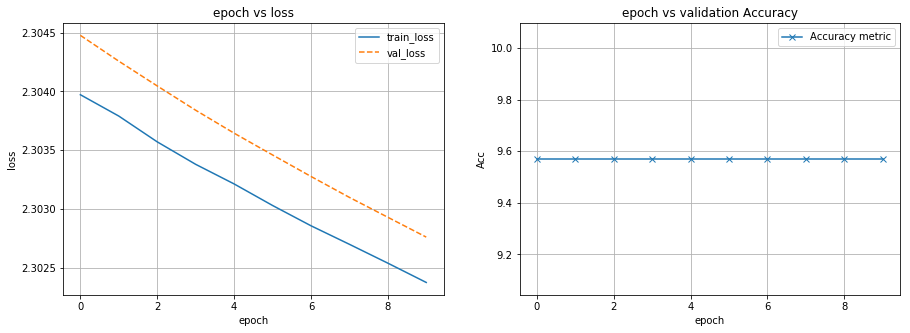

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3043300252372085, Val Loss: 2.304298316376119, Val Acc: 12.75


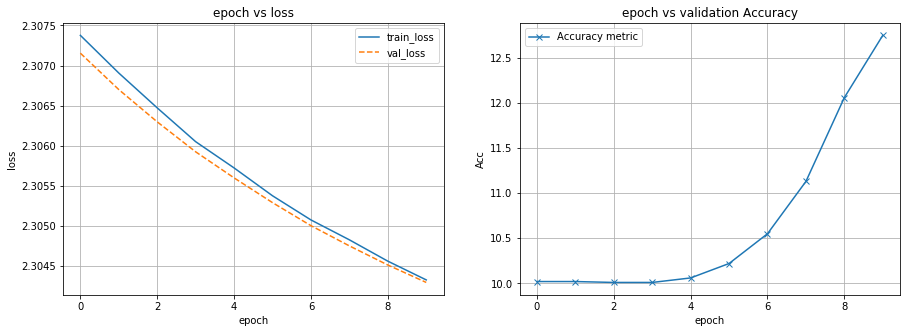

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.3031893545827167, Val Loss: 2.303218503541584, Val Acc: 9.71


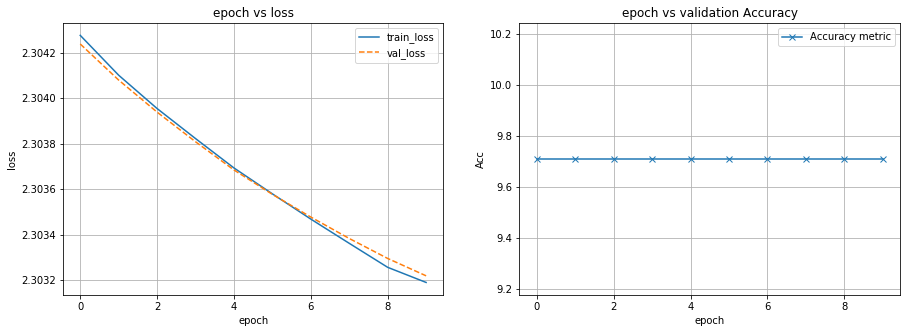

MLP(
  (fc): Linear(in_features=3072, out_features=150, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=150, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): Linear(in_features=150, out_features=150, bias=True)
    (4): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc2): Linear(in_features=150, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 9, Train Loss: 2.303319142649349, Val Loss: 2.302394872979273, Val Acc: 10.45


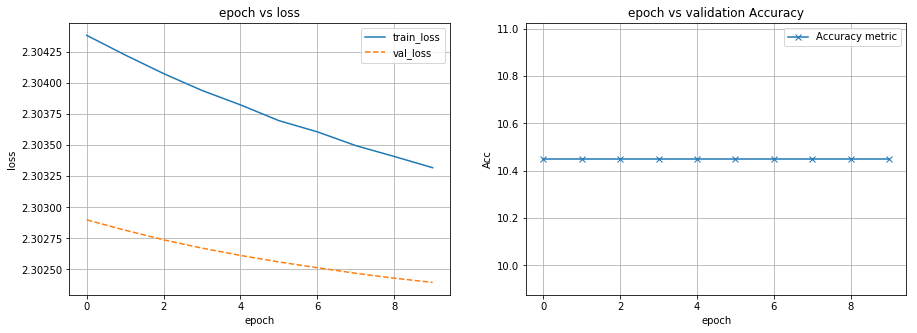

In [8]:
main()